In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      104883

In [2]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)

x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 30, 30, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 6, 6, 128)         0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [3]:
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [8]:
import os
from tensorflow.keras.preprocessing import image

(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

x_train = x_train[y_train.flatten() == 6]

x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = '/content/drive/MyDrive/Colab Notebooks/datasets/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    generated_images = generator.predict(random_latent_vectors)

    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])

    labels += 0.05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)

    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    if step % 100 == 0:
        gan.save_weights('gan.h5')

        print('스텝 %s에서 판별자 손실: %s' % (step, d_loss))
        print('스텝 %s에서 적대적 손실: %s' % (step, a_loss))

        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

스텝 0에서 판별자 손실: 0.6804543733596802
스텝 0에서 적대적 손실: 0.6497493386268616
스텝 100에서 판별자 손실: 0.6890763640403748
스텝 100에서 적대적 손실: 0.7577543258666992
스텝 200에서 판별자 손실: 0.6992138624191284
스텝 200에서 적대적 손실: 0.8921961784362793
스텝 300에서 판별자 손실: 0.6915251016616821
스텝 300에서 적대적 손실: 0.7002824544906616
스텝 400에서 판별자 손실: 0.7016614675521851
스텝 400에서 적대적 손실: 0.7443892359733582
스텝 500에서 판별자 손실: 0.6940037608146667
스텝 500에서 적대적 손실: 0.7626518607139587
스텝 600에서 판별자 손실: 1.0899631977081299
스텝 600에서 적대적 손실: 0.8179904818534851
스텝 700에서 판별자 손실: 0.6889094114303589
스텝 700에서 적대적 손실: 0.7578237056732178
스텝 800에서 판별자 손실: 0.7049548029899597
스텝 800에서 적대적 손실: 0.7931138277053833
스텝 900에서 판별자 손실: 0.6858012080192566
스텝 900에서 적대적 손실: 0.7123100161552429
스텝 1000에서 판별자 손실: 0.6869970560073853
스텝 1000에서 적대적 손실: 0.7463937997817993
스텝 1100에서 판별자 손실: 0.7240415811538696
스텝 1100에서 적대적 손실: 0.7489287853240967
스텝 1200에서 판별자 손실: 0.678460419178009
스텝 1200에서 적대적 손실: 0.7042055726051331
스텝 1300에서 판별자 손실: 0.7048912048339844
스텝 1300에서 적대적 손실: 0.748220

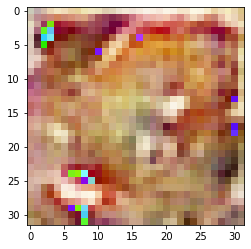

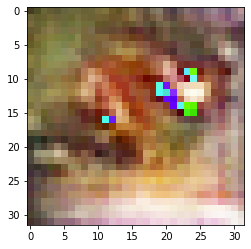

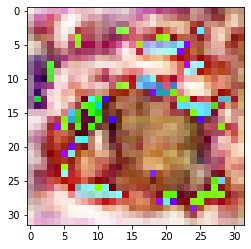

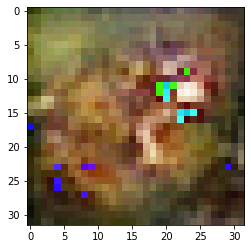

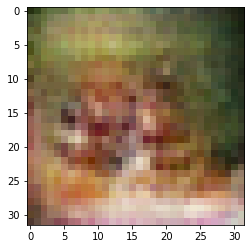

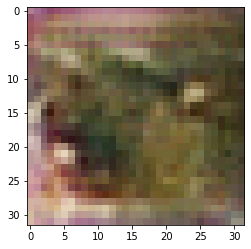

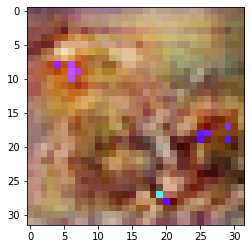

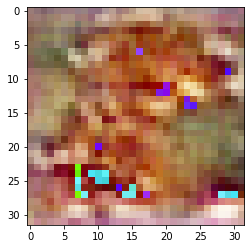

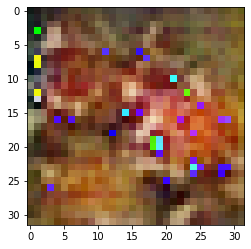

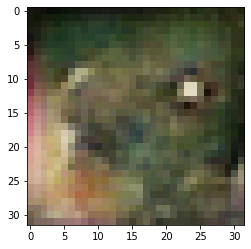

In [9]:
import matplotlib.pyplot as plt
random_latent_vectors = np.random.normal(size=(10, latent_dim))

generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()